In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RNN gates = sliding windows over candidates.

For LSTM style unbounded gates:
$$
    h_t = p_th_{t-1} + z_t
$$
Suppose $p_i = 0.99$ for $i \in \{1, \dots, 1000\}$, what does the weighting look like at time 1001?

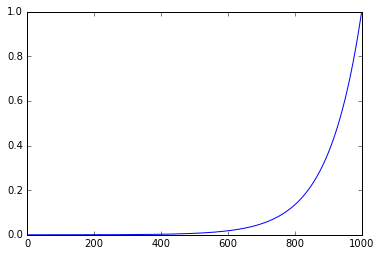

In [2]:
times = np.arange(1000)
window = np.power(0.99, times)[::-1]
plt.plot(window)

What if it fluctuates randomly?

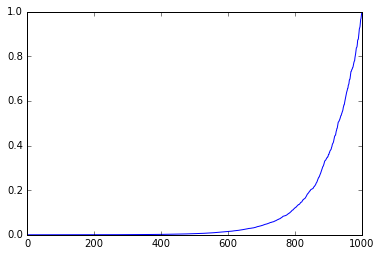

In [17]:
gates = np.random.uniform(0.98, 1.0, size=(1000,))
window = np.cumprod(gates)[::-1]
plt.plot(window)

GRUs (and our new friend) have gates that look like:
$$
    h_t = p_th_{t-1} + (1-p_t)z_t
$$ (although in some GRU papers it's the other way around). This is a little bit more tricky to calculate the sliding window, but that's why we're here.

Let's write out a few in full to see if we can find a general form.
$$
\begin{align}
    h_0 &= z_0 \\
    h_1 &= p_1z_0 + (1-p_1)z_1 \\
    h_2 &= p_2p_1z_0 + p_2(1-p_1)z_1 + (1-p_2)z_2 \\
    h_3 &= p_3p_2p_1z_0 + p_3p_2(1-p_1)z_1 + p_3(1-p_2)z_2 + (1-p_3)z_3 \\
    h_4 &= p_4p_3p_2p_1z_0 + p_4p_3p_2(1-p_1)z_1 + p_4p_3(1-p_2)z_2 + p_4(1-p_3)z_3 + (1-p_4)z_4
\end{align}
$$

_I THINK WE ARE GOING TO HAVE TO SUM UP TO t-1 TO MAKE THIS WORK OUT?_

Looks like it's going to be as above, but also multiplied by $(1-p_t)$: (define $p_0=0$)

$$
    h_t = \sum_{i=0}^t \left(\prod_{j=i+1}^t p_j\right) (1 - p_i) z_i
$$

Now it feels as though these coefficients should sum to one, so let's consider
$$
    \sum_{i=0}^t (1-p_i) \prod_{j=i+1}^tp_j
$$


In the case where $t=3$:
$$
\begin{align}
    p_3p_2p_1 + p_2p_3(1-p_1) + p_3(1-p_2) + (1-p_3) &= p_3p_2p_1 + p_2p_3 - p_2p_3p_1 + p_3 - p_3p_2 + 1 - p_3 \\
    &= 1
\end{align}
$$

Looks like they should all cancel out, now let's generalise and see if we can turn it into a telescoping sum:
$$
\begin{align}
    &\sum_{i=0}^t (1-p_i) \prod_{j=i+1}^tp_j \\
    &= \sum_{i=0}^t \prod_{j=i+1}^tp_j - \prod_{k=i}^tp_k \\
    &= \sum_{i=0}^t (p_{i+1}\dots p_t) - (p_i\dots p_t) \\
\end{align}
$$
Now we clearly have a telescoping sum, the left hand term at $i$ is the right hand side at $i+1$. They occur with
opposite signs. At the end we will be left with
$$
    -(p_0\dots p_t) + 
$$

I think we are going to have to define

0.999956828753


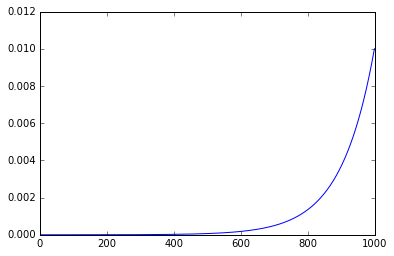

In [21]:
# first let all have the same value
window = np.power(0.99, times)[::-1]
window *= (1 - 0.99)

print(window.sum())
plt.plot(window)

It's the same, but smaller because it sums pretty much to one. But what if it jumps around a bit?

47.758122590531023

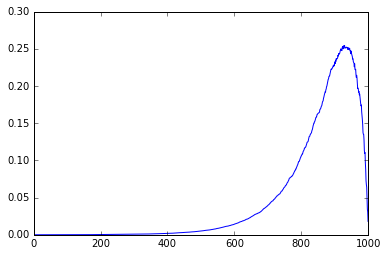

In [22]:
window = np.cumprod(gates)
window[:-1] *= 1.0 - window[1:]
window = window[::-1]

plt.plot(window)
window.sum()
# something wrong